In [1]:
pip install tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.0 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
#########      Importing all the required libraries    ##########
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import tiktoken as ttk
from tqdm import tqdm
import os
import urllib.request
from dataclasses import dataclass, field, asdict, replace
from typing import Dict


In [5]:


# Getting Raw Text

if not os.path.exists("the-verdict.txt"):
    url  = ("https://raw.githubusercontent.com/rasbt/"
           "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
           "the-verdict.txt")
    file_path = "the-verdict.txt"
    urllib.request.urlretrieve(url, file_path)


In [6]:

@dataclass
class GPTConfig:
    vocab_size: int = 50257
    context_length: int = 512
    emb_dim: int = 768
    n_heads: int = 12
    n_layers: int = 12
    drop_rate: float = 0.1
    qkv_bias: bool = float

    def to_dict(self) -> dict:
        return asdict(self)

    def __repr__(self) -> str:
        config_dict = self.to_dict()
        formatted_items = [f'"{key}": {repr(value)}' for key, value in config_dict.items()]
        return "GPT_CONFIG_124M = {\n    " + ",\n    ".join(formatted_items) + "\n}"

@dataclass
class DataConfig:
    dataPath: str = r'the-verdict.txt'
    max_lenght: int = GPTConfig.context_length
    batch_size: int = 64
    train_ratio: float = 0.90
    stride: int = GPTConfig.context_length

DataConfig = DataConfig()
GPTConfig = GPTConfig()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [7]:
print(device)

cpu


In [8]:
def read_txt(path: str) -> str:
    try:
        with open(path, "r", encoding= "utf-8") as f:
            raw_text = f.read()
        return raw_text
    except FileNotFoundError:
        print(f"Error: File not found at {path}")
        return ""
    except Exception as e:
        print(f"An error occurred: {e}")
        return ""

def text_to_tokens_ids(text, tokenizer):
    encoded = tokenizer.encode(text)
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

In [9]:
class LLMDataset(Dataset):
    def __init__(self, txt, tokenizer, max_length: int, stride: int):
        self.tokenizer = tokenizer
        token_ids = tokenizer.encode(txt)
        self.input_ids = []
        self.target_ids = []

        for i in tqdm(range(0, len(token_ids) - max_length, stride)):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1:i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

def LLM_DataLoader(txt, tokenizer, batch_size: int, max_length: int, stride: int,
                   shuffle: bool = True, drop_last: bool = True):
    llmdataset = LLMDataset(txt, tokenizer, max_length, stride)
    llmdataloader = DataLoader(llmdataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)
    return llmdataloader

In [10]:

raw_data = read_txt(DataConfig.dataPath)
tokenizer = ttk.get_encoding("gpt2")

total_token = len(tokenizer.encode(raw_data))
print(f"-> Number of Characters : {len(raw_data)}\n-> Number of Tokens : {total_token}")


-> Number of Characters : 20479
-> Number of Tokens : 5145


In [11]:
# Splitting Data into training and validation

train_ratio = DataConfig.train_ratio
split_idxs = int(train_ratio * len(raw_data))
train_data = raw_data[:split_idxs]
val_data = raw_data[split_idxs:]

In [12]:

print(f"Length of Training Data : {len(train_data)}")
print(f"Length of Validation Data: {len(val_data)}")


Length of Training Data : 18431
Length of Validation Data: 2048


In [13]:
# Sanity Check
if total_token * (train_ratio) < GPTConfig.context_length:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPTConfig.context_length or "
          "increase the `training_ratio`")
if total_token * (1-train_ratio) < GPTConfig.context_length:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPTConfig.context_length` or "
          "decrease the `training_ratio`")


In [14]:

# Processing data to use in LLm as input

train_dataloader = LLM_DataLoader(
    txt = train_data,
    tokenizer= tokenizer,
    max_length= DataConfig.max_lenght,
    batch_size= DataConfig.batch_size,
    stride= DataConfig.stride,
    shuffle= False,
    drop_last= False
)

print("View Example:")
dataiter = iter(train_dataloader)
firstbatch = next(dataiter)
print(f"Inputs: \n{firstbatch[0]} \ntarget: \n{firstbatch[1]}")
print(firstbatch[0].shape)

100%|██████████| 9/9 [00:00<00:00, 3080.27it/s]


View Example:
Inputs: 
tensor([[   40,   367,  2885,  ...,  9074,    13,   402],
        [  271, 10899,   550,  ...,   691, 12226,   318],
        [  284,  1234,  8737,  ..., 19217, 24887, 13431],
        ...,
        [ 1310,  1165,   881,  ...,   514,  2474,   198],
        [  198,  1544, 13818,  ...,   284,   616,   835],
        [  286,  1762,    30,  ...,  1517,   484,  1444]]) 
target: 
tensor([[  367,  2885,  1464,  ...,    13,   402,   271],
        [10899,   550,   366,  ..., 12226,   318,   284],
        [ 1234,  8737,   656,  ..., 24887, 13431,    13],
        ...,
        [ 1165,   881, 40642,  ...,  2474,   198,   198],
        [ 1544, 13818,  4622,  ...,   616,   835,   286],
        [ 1762,    30,  2011,  ...,   484,  1444,   616]])
torch.Size([9, 512])


In [15]:

val_dataloader = LLM_DataLoader(
    txt = val_data,
    tokenizer= tokenizer,
    max_length= DataConfig.max_lenght,
    batch_size= DataConfig.batch_size,
    stride= DataConfig.stride,
    shuffle= False,
    drop_last= False
)

dataiter = iter(val_dataloader)
firstbatch = next(dataiter)
print(firstbatch[0].shape)

100%|██████████| 1/1 [00:00<00:00, 2442.81it/s]


torch.Size([1, 512])


In [16]:

######       Creating Attention Mechanism  #########
class MultiHeadAttention(nn.Module):

    def __init__(self, d_in: int, d_out: int, context_length: int,
                 dropout: float, num_heads: int, qkv_bias: bool = False):
        super(MultiHeadAttention, self).__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.w_queries = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.w_keys = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.w_values = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)

        self.register_buffer(
            'mask',
            torch.tril(torch.ones(context_length, context_length)).unsqueeze(0).unsqueeze(0)
        )

    def forward(self, x):
        batches, num_tokens, dim_in = x.shape

        # Linear projections
        queries = self.w_queries(x)
        keys = self.w_keys(x)
        values = self.w_values(x)

        # Reshape and transpose for multi-head attention
        queries = queries.view(batches, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        keys = keys.view(batches, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        values = values.view(batches, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)

        # Attention score calculation
        attn_scores = (queries @ keys.transpose(2, 3)) / (self.head_dim ** 0.5)

        # Apply mask: Broadcasting across batches and heads
        attn_scores = attn_scores.masked_fill(self.mask[:, :, :num_tokens, :num_tokens] == 0, float('-inf'))

        # Softmax to get attention weights
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Context vector computation
        context_vec = (attn_weights @ values).transpose(1, 2)
        context_vec = context_vec.contiguous().view(batches, num_tokens, self.d_out)

        # Final linear projection
        context_vec = self.out_proj(context_vec)

        return context_vec


In [17]:
#######     Building LLM         ######


In [18]:

# Createing Normalization Layer
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super(LayerNorm, self).__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim = -1, keepdim = True)
        var = x.var(dim = -1, keepdim = True)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift


In [19]:

# GELU Activation

class GELU(nn.Module):
    def __init__(self):
        super(GELU, self).__init__()
    def forward(self, x):
        return 0.5 * x * (1+torch.tanh(torch.sqrt(torch.tensor(2.0/torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))


In [20]:

# Feed Forward NetWork

class FeedForwardGELU(nn.Module):
    def __init__(self, cfg):
        super(FeedForwardGELU, self).__init__()
        emb_dim = cfg.emb_dim

        self.layers = nn.Sequential(
            nn.Linear(emb_dim, 4*emb_dim),
            GELU(),
            nn.Linear(4 * emb_dim, emb_dim)
        )
    def forward(self, x):
        return self.layers(x)


In [21]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg.emb_dim,
            d_out=cfg.emb_dim,
            context_length=cfg.context_length,
            num_heads=cfg.n_heads,
            dropout=cfg.drop_rate,
            qkv_bias=cfg.qkv_bias)
        self.ff = FeedForwardGELU(cfg)
        self.norm1 = LayerNorm(cfg.emb_dim)
        self.norm2 = LayerNorm(cfg.emb_dim)
        self.dropout = nn.Dropout(cfg.drop_rate)

    def forward(self, x):

        resid_conn = x
        x = self.norm1(x)  # pre-LayerNorm
        x = self.att(x)
        x = self.dropout(x)
        x = x + resid_conn

        resid_conn = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.dropout(x)
        x = x + resid_conn
        return x

In [22]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg.vocab_size, cfg.emb_dim)
        self.pos_emb = nn.Embedding(cfg.context_length, cfg.emb_dim)
        self.dropout_emb = nn.Dropout(cfg.drop_rate)
        # Corrected typo: TransferBlock to TransformerBlock
        # Accessing cfg.emb_dim instead of self.emb_dim
        self.transformer_block = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg.n_layers)])
        self.final_norm = LayerNorm(cfg.emb_dim)
        self.out_ff = nn.Linear(cfg.emb_dim, cfg.vocab_size, bias=False)

    def forward(self, idx):
        batch_size, seq_len = idx.shape
        tok_embeds = self.tok_emb(idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=idx.device))

        x = tok_embeds + pos_embeds
        # Applying dropout to the embeddings
        x = self.dropout_emb(x)
        # Passing through the transformer blocks
        x = self.transformer_block(x)
        # Applying final normalization
        x = self.final_norm(x)
        logits = self.out_ff(x)
        return logits

In [23]:
#############           Training loop       ############


In [24]:

# Generate Function
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]

        # Getting the prediction
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        idx_next = torch.argmax(logits, dim= -1, keepdim= True)
        idx = torch.cat((idx, idx_next), dim = 1)

    return idx

In [25]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float('-inf')).to(logits.device), logits)

        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            # Changed num_samples to 1
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        if idx_next == eos_id:
            break
        idx = torch.cat((idx, idx_next), dim=1)

    return idx

In [26]:

def generate_print_sample(model, tokenizer, device, start_context, temperature, top_k, eos_id):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_tokens_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate(
            model= model,
            idx = encoded,
            max_new_tokens= 50,
            context_size= context_size,
            temperature= temperature,
            top_k= top_k,
            eos_id= eos_id
        )

    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()


In [27]:

# Calculating the training and validation losses

def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

def calc_loss_loader(data_loader, model, device, num_batches = None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()

        else:
            break

    return total_loss / num_batches

In [28]:

# Training and Evaluation Methode
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context, tokenizer, temperature, top_k, eos_id):
    train_losses , val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:03d}): "
                  f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Printing the sample text
        print("Example: ")
        generate_print_sample(
            model,
            tokenizer,
            device,
            start_context,
            temperature,
            top_k,
            eos_id
        )
        print('---'*10)
    # Returning the collected losses and token count
    return train_losses, val_losses, track_tokens_seen # Added this line to return the desired values

In [29]:

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [30]:
# Training the model

def initialize_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)

torch.manual_seed(123)
model = GPTModel(GPTConfig)
model.to(device)
model.apply(initialize_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00009, weight_decay=0.1)
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

num_epochs = 50

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_dataloader, val_dataloader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves", tokenizer=tokenizer,
        top_k=10,temperature=0.4,eos_id=None
)

Ep 1 (Step 000): Train loss 10.566, Val loss 10.624
Example: 
Every effort moves Surgery the Ens captured huhRemoved I PEOPLE thearbonDub the supply stubborn PEOPLERegistered.:.nation Mah Veget PEOPLE ocratesselling worldview the populous the�die  commuting job the mitigation othes PEOPLE PEOPLE obstruct motif PEOPLE conceal, Penalty enacted of creativevard
------------------------------
Example: 
Every effort moves the the  and,  the ", I. PEOPLE PEOPLE PEOPLE PEOPLE the the .  the the.-- the fellows the,,� tyr the. of, the   .� was the.  the the the of
------------------------------
Example: 
Every effort moves, was I   the PEOPLE,  was the  and the.      the, the--. had. the  ,, his I to  the I had the. the the, the I.,,,
------------------------------
Example: 
Every effort moves" the the the    his his. the the the was,,. the the the the     the the, the the the.,  . the of, the the the I the the the  the the,
------------------------------
Example: 
Every effort moves the the the

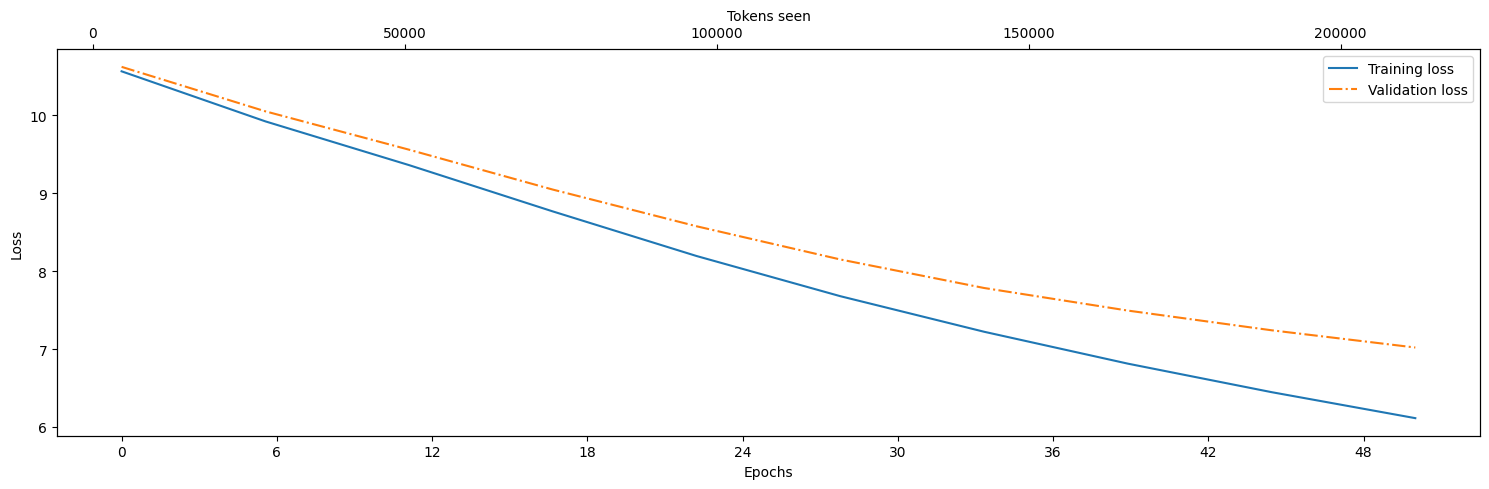

In [31]:
# Ep 46 (Step 045): Train loss 5.668, Val loss 6.691 ->4

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(15, 5))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [32]:
model.to("cpu")
model.eval()


token_ids = generate(
    model=model,
    # Changed text_to_token_ids to text_to_tokens_ids
    idx=text_to_tokens_ids("quite insensible to the irony", tokenizer),
    max_new_tokens=25,
    context_size=GPTConfig.context_length,
    top_k=5,temperature=0.7,eos_id=None

)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 quite insensible to the irony,, and, and he the a the, he was.

 the the.









In [33]:
# Loading and saving model weights in PyTorch

In [34]:
print('saving model and optimizer...')
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)
print('Done')

saving model and optimizer...
Done


In [35]:
#  delete model
# del model

# print(' then we deleted model from memory to ensure we use loaded model')

print('loading...')
checkpoint = torch.load("model_and_optimizer.pth", weights_only=True)

model = GPTModel(GPTConfig)
model.to(device)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();
print('Done')

loading...
Done


In [36]:
#  now we can train again or use

num_epochs = 2
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_dataloader, val_dataloader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves ", tokenizer=tokenizer,
        top_k=10,temperature=2.7,eos_id=None
)

Ep 1 (Step 000): Train loss 5.853, Val loss 6.823
Example: 
Every effort moves  had.--, he I of a I his in--and, I, the, he  his he, and I, the-- I the of the, he was a, I had and in he the "--, his --
------------------------------
Example: 
Every effort moves  in his, he.,-- the of his I. He the to his of of-- it--..  G's. Mrs's the of and his he the a a " of.    the his to me, his he
------------------------------


In [37]:
from transformers import GPT2Model

gpt2_small=  "openai-community/gpt2"

gpt_hf = GPT2Model.from_pretrained(gpt2_small, cache_dir="checkpoints")
gpt_hf.eval()


/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.10/site-packages/torch_xla/__init__.py:251: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(
E0000 00:00:1746286949.422563      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:230
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Fall

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D(nf=2304, nx=768)
        (c_proj): Conv1D(nf=768, nx=768)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=3072, nx=768)
        (c_proj): Conv1D(nf=768, nx=3072)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [38]:
copyConfig = replace(GPTConfig)
copyConfig.qkv_bias =True
copyConfig.context_length =  1024
copyConfig.drop_rate= 0.0
copyConfig

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.0,
    "qkv_bias": True
}

In [39]:
def assign_check(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(right.clone().detach())


In [40]:
def load_weights(gpt, gpt_hf):

    d = gpt_hf.state_dict()

    gpt.pos_emb.weight = assign_check(gpt.pos_emb.weight, d["wpe.weight"])
    gpt.tok_emb.weight = assign_check(gpt.tok_emb.weight, d["wte.weight"])

    for b in range(copyConfig.n_layers):
        q_w, k_w, v_w = np.split(d[f"h.{b}.attn.c_attn.weight"], 3, axis=-1)
        gpt.transformer_blocks[b].att.w_queries.weight = assign_check(gpt.transformer_blocks[b].att.w_queries.weight, q_w.T)
        gpt.transformer_blocks[b].att.w_keys.weight = assign_check(gpt.transformer_blocks[b].att.w_keys.weight, k_w.T)
        gpt.transformer_blocks[b].att.w_values.weight = assign_check(gpt.transformer_blocks[b].att.w_values.weight, v_w.T)

        q_b, k_b, v_b = np.split(d[f"h.{b}.attn.c_attn.bias"], 3, axis=-1)
        gpt.transformer_blocks[b].att.w_queries.bias = assign_check(gpt.transformer_blocks[b].att.w_queries.bias, q_b)
        gpt.transformer_blocks[b].att.w_keys.bias = assign_check(gpt.transformer_blocks[b].att.w_keys.bias, k_b)
        gpt.transformer_blocks[b].att.w_values.bias = assign_check(gpt.transformer_blocks[b].att.w_values.bias, v_b)


        gpt.transformer_blocks[b].att.out_proj.weight = assign_check(gpt.transformer_blocks[b].att.out_proj.weight, d[f"h.{b}.attn.c_proj.weight"].T)
        gpt.transformer_blocks[b].att.out_proj.bias = assign_check(gpt.transformer_blocks[b].att.out_proj.bias, d[f"h.{b}.attn.c_proj.bias"])

        gpt.transformer_blocks[b].ff.layers[0].weight = assign_check(gpt.transformer_blocks[b].ff.layers[0].weight, d[f"h.{b}.mlp.c_fc.weight"].T)
        gpt.transformer_blocks[b].ff.layers[0].bias = assign_check(gpt.transformer_blocks[b].ff.layers[0].bias, d[f"h.{b}.mlp.c_fc.bias"])
        gpt.transformer_blocks[b].ff.layers[2].weight = assign_check(gpt.transformer_blocks[b].ff.layers[2].weight, d[f"h.{b}.mlp.c_proj.weight"].T)
        gpt.transformer_blocks[b].ff.layers[2].bias = assign_check(gpt.transformer_blocks[b].ff.layers[2].bias, d[f"h.{b}.mlp.c_proj.bias"])

        gpt.transformer_blocks[b].norm1.scale = assign_check(gpt.transformer_blocks[b].norm1.scale, d[f"h.{b}.ln_1.weight"])
        gpt.transformer_blocks[b].norm1.shift = assign_check(gpt.transformer_blocks[b].norm1.shift, d[f"h.{b}.ln_1.bias"])
        gpt.transformer_blocks[b].norm2.scale = assign_check(gpt.transformer_blocks[b].norm2.scale, d[f"h.{b}.ln_2.weight"])
        gpt.transformer_blocks[b].norm2.shift = assign_check(gpt.transformer_blocks[b].norm2.shift, d[f"h.{b}.ln_2.bias"])

        gpt.final_norm.scale = assign_check(gpt.final_norm.scale, d[f"ln_f.weight"])
        gpt.final_norm.shift = assign_check(gpt.final_norm.shift, d[f"ln_f.bias"])
        gpt.out_ff.weight = assign_check(gpt.out_ff.weight, d["wte.weight"])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gpt = GPTModel(copyConfig)
load_weights(gpt, gpt_hf)


In [43]:
# test
token_ids = generate(
    model=gpt.to(device),
    idx=text_to_tokens_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=30,
    context_size=copyConfig.context_length,
    top_k=1,
    temperature=1.0
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves youfunding Impsteel Sil Sil Sil Sil Sil Sil philosoph philosoph philosoph philosoph philosoph philosoph philosoph philosoph philosoph philosoph philosoph philosoph philosoph philosoph philosoph philosoph philosoph philosoph philosoph philosoph philosoph


In [44]:
#  Loading pretrained weights from OpenAI by Tensorflow

In [45]:
import tensorflow as tf
import json

def download_file(url, destination):
    # Send a GET request to download the file

    try:
        with urllib.request.urlopen(url) as response:
            # Get the total file size from headers, defaulting to 0 if not present
            file_size = int(response.headers.get("Content-Length", 0))

            # Check if file exists and has the same size
            if os.path.exists(destination):
                file_size_local = os.path.getsize(destination)
                if file_size == file_size_local:
                    print(f"File already exists and is up-to-date: {destination}")
                    return

            # Define the block size for reading the file
            block_size = 1024  # 1 Kilobyte

            # Initialize the progress bar with total file size
            progress_bar_description = os.path.basename(url)  # Extract filename from URL
            with tqdm(total=file_size, unit="iB", unit_scale=True, desc=progress_bar_description) as progress_bar:
                # Open the destination file in binary write mode
                with open(destination, "wb") as file:
                    # Read the file in chunks and write to destination
                    while True:
                        chunk = response.read(block_size)
                        if not chunk:
                            break
                        file.write(chunk)
                        progress_bar.update(len(chunk))  # Update progress bar
    except urllib.error.HTTPError:
        s = (
            f"The specified URL ({url}) is incorrect, the internet connection cannot be established,"
            "\nor the requested file is temporarily unavailable.\nPlease visit the following website"
            " for help: https://github.com/rasbt/LLMs-from-scratch/discussions/273")
        print(s)

def load_gpt2_params_from_tf_ckpt(ckpt_path, settings):
    # Initialize parameters dictionary with empty blocks for each layer
    params = {"blocks": [{} for _ in range(settings["n_layer"])]}

    # Iterate over each variable in the checkpoint
    for name, _ in tf.train.list_variables(ckpt_path):
        # Load the variable and remove singleton dimensions
        variable_array = np.squeeze(tf.train.load_variable(ckpt_path, name))

        # Process the variable name to extract relevant parts
        variable_name_parts = name.split("/")[1:]  # Skip the 'model/' prefix

        # Identify the target dictionary for the variable
        target_dict = params
        if variable_name_parts[0].startswith("h"):
            layer_number = int(variable_name_parts[0][1:])
            target_dict = params["blocks"][layer_number]

        # Recursively access or create nested dictionaries
        for key in variable_name_parts[1:-1]:
            target_dict = target_dict.setdefault(key, {})

        # Assign the variable array to the last key
        last_key = variable_name_parts[-1]
        target_dict[last_key] = variable_array

    return params
def download_and_load_gpt2(model_size, models_dir):
    # Validate model size
    allowed_sizes = ("124M", "355M", "774M", "1558M")
    if model_size not in allowed_sizes:
        raise ValueError(f"Model size not in {allowed_sizes}")

    # Define paths
    model_dir = os.path.join(models_dir, model_size)
    base_url = "https://openaipublic.blob.core.windows.net/gpt-2/models"
    filenames = [
        "checkpoint", "encoder.json", "hparams.json",
        "model.ckpt.data-00000-of-00001", "model.ckpt.index",
        "model.ckpt.meta", "vocab.bpe"
    ]

    # Download files
    os.makedirs(model_dir, exist_ok=True)
    for filename in filenames:
        file_url = os.path.join(base_url, model_size, filename)
        file_path = os.path.join(model_dir, filename)
        download_file(file_url, file_path)

    # Load settings and params
    tf_ckpt_path = tf.train.latest_checkpoint(model_dir)
    settings = json.load(open(os.path.join(model_dir, "hparams.json")))
    params = load_gpt2_params_from_tf_ckpt(tf_ckpt_path, settings)

    return settings, params


In [46]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")


checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 39.6kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 1.19MiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 41.7kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [01:35<00:00, 5.19MiB/s] 
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 2.40MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 708kiB/s] 
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 839kiB/s] 


In [47]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])
[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


In [48]:
gpt = GPTModel(copyConfig)
gpt.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (dropout_emb): Dropout(p=0.0, inplace=False)
  (transformer_block): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (w_queries): Linear(in_features=768, out_features=768, bias=True)
        (w_keys): Linear(in_features=768, out_features=768, bias=True)
        (w_values): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForwardGELU(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (w_queries): Linear

In [ ]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

def load_weights_into_gpt_tf(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
#
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.transformer_blocks[b].att.w_queries.weight = assign(
            gpt.transformer_blocks[b].att.w_queries.weight, q_w.T)
        gpt.transformer_blocks[b].att.w_keys.weight = assign(
            gpt.transformer_blocks[b].att.w_keys.weight, k_w.T)
        gpt.transformer_blocks[b].att.w_values.weight = assign(
            gpt.transformer_blocks[b].att.w_values.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.transformer_blocks[b].att.w_queries.bias = assign(
            gpt.transformer_blocks[b].att.w_queries.bias, q_b)
        gpt.transformer_blocks[b].att.w_keys.bias = assign(
            gpt.transformer_blocks[b].att.w_keys.bias, k_b)
        gpt.transformer_blocks[b].att.w_values.bias = assign(
            gpt.transformer_blocks[b].att.w_values.bias, v_b)

        gpt.transformer_blocks[b].att.out_proj.weight = assign(
            gpt.transformer_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.transformer_blocks[b].att.out_proj.bias = assign(
            gpt.transformer_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.transformer_blocks[b].ff.layers[0].weight = assign(
            gpt.transformer_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.transformer_blocks[b].ff.layers[0].bias = assign(
            gpt.transformer_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.transformer_blocks[b].ff.layers[2].weight = assign(
            gpt.transformer_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.transformer_blocks[b].ff.layers[2].bias = assign(
            gpt.transformer_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.transformer_blocks[b].norm1.scale = assign(
            gpt.transformer_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.transformer_blocks[b].norm1.shift = assign(
            gpt.transformer_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.transformer_blocks[b].norm2.scale = assign(
            gpt.transformer_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.transformer_blocks[b].norm2.shift = assign(
            gpt.transformer_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_ff.weight = assign(gpt.out_ff.weight, params["wte"])


load_weights_into_gpt_tf(gpt, params)
gpt.to(device);


In [50]:
torch.manual_seed(123)
model.to(device)


num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    gpt, train_dataloader, val_dataloader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves ", tokenizer=tokenizer,
        top_k=5,temperature=0.7,eos_id=None
)

Ep 1 (Step 000): Train loss 11.003, Val loss 10.960
Example: 
Every effort moves  endotb endotestablish destinationsb sum demeanor demeanor destinationsivals destinations Sherivalsb destinations sum sumaintain sum demeanor destinations destinationsivals destinations sum demeanor demeanor destinationsb sum destinations destinationsivalsb sum destinations JavaScript JavaScript sum destinations JavaScriptthemeال JavaScriptال JavaScriptivals expl Sand
------------------------------
Example: 
Every effort moves b demeanorb demeanor endot destinations destinationsb destinations canonicalb destinations destinations canonical canonicalb demeanor canonical sum sum sumivalsb canonical destinations destinationsivals canonical canonical sum sum_{ canonical_{ JavaScript JavaScripttheme JavaScript sum destinationsivals JavaScriptivals canonical Caryال JavaScript destinations Cary sum
------------------------------
Example: 
Every effort moves Parser endotbbaintain sum endotbaintain sum destinationsi

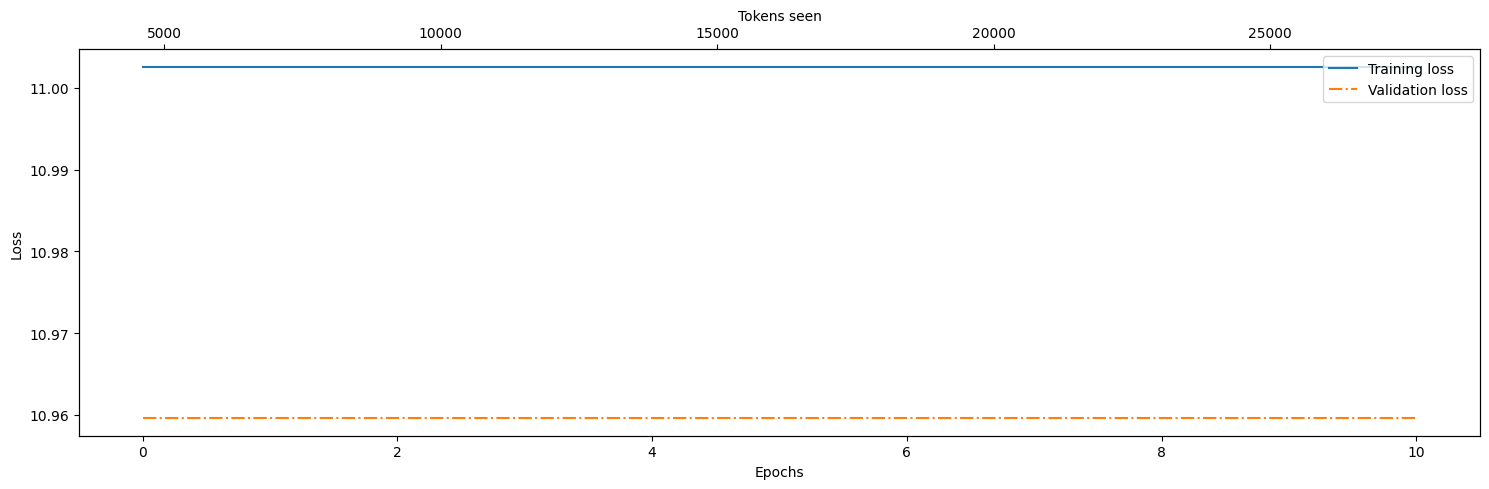

In [51]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [52]:
token_ids = generate(
    model=gpt.to(device),
    idx=text_to_tokens_ids("Every effort moves ", tokenizer).to(device),
    max_new_tokens=30,
    context_size=copyConfig.context_length,
    top_k=1,
    temperature=1.0
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves Parser endot endot endot endot endot endot endot endot endot endot endot endot endot endot endot endottheme destinations destinations destinations destinations destinations destinations destinations destinations destinations destinations destinations destinations
